In [41]:
# Loading all required libraries
import pandas as pd
import seaborn as sns
import pickle
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from xgboost import plot_importance
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
sns.set(rc={'figure.figsize':(10,10)})

In [2]:
# Loading credit card fradulent dataset
credit_dataset = pd.read_csv('creditcard.csv')
credit_dataset.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Exploratory Data Analysis (EDA)

In [3]:
#Checking missing and null values
credit_dataset.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

<AxesSubplot:>

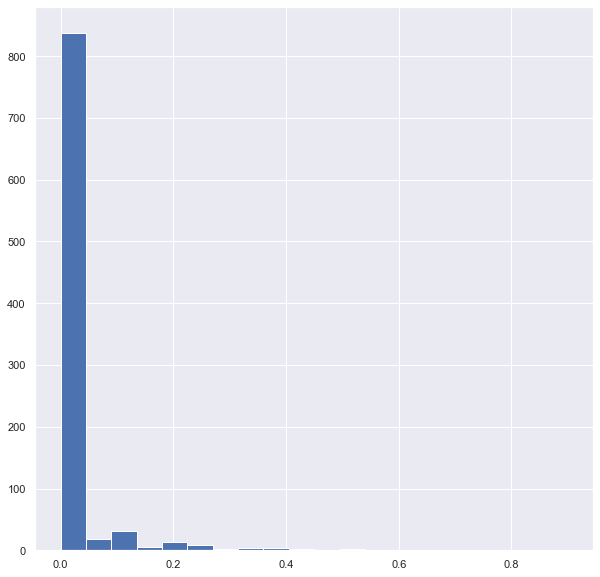

In [4]:
#Calculating the correaltions of all features and visualizing with the histogram
corr = abs(credit_dataset.corr())
filtered_corr = corr[(corr>=.0)&(corr<1)]
unstack_corr = filtered_corr.unstack().dropna()
unstack_corr.hist(bins=20,range=[0.0,0.9])

<AxesSubplot:>

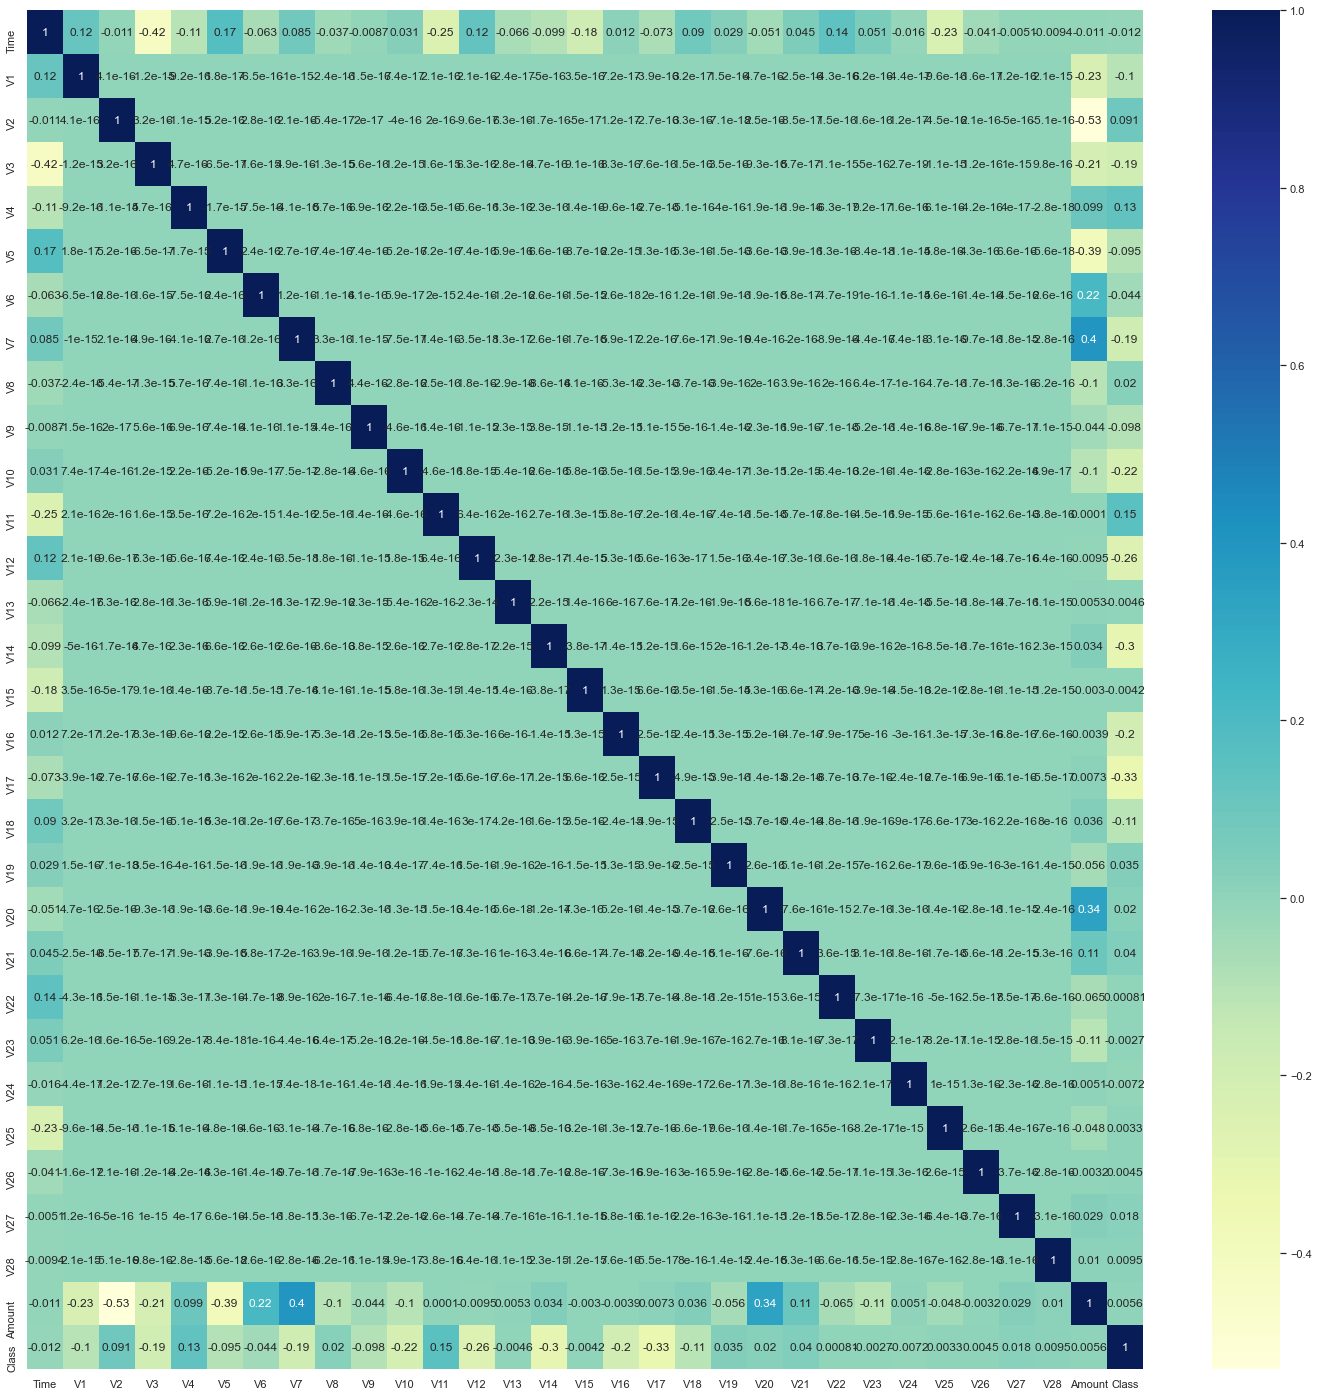

In [5]:
#Heatmap of correlations
sns.set(rc={'figure.figsize':(25,25)})
sns.heatmap(credit_dataset.corr(),cmap='YlGnBu',annot=True)

In [5]:
#Checking the distribution of Fraud and Non-Fradulent Classes
credit_dataset['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Time', ylabel='Density'>

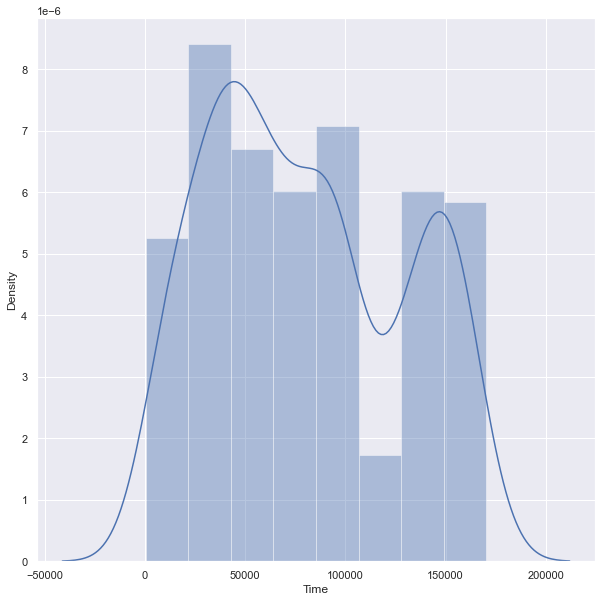

In [6]:
#Visualization of a distrubtion plot to find any insight between Fradulent Class and Time
sns.set(rc={'figure.figsize':(10,10)})
sns.distplot(credit_dataset[credit_dataset['Class']==1]['Time'])

/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Time', ylabel='Density'>

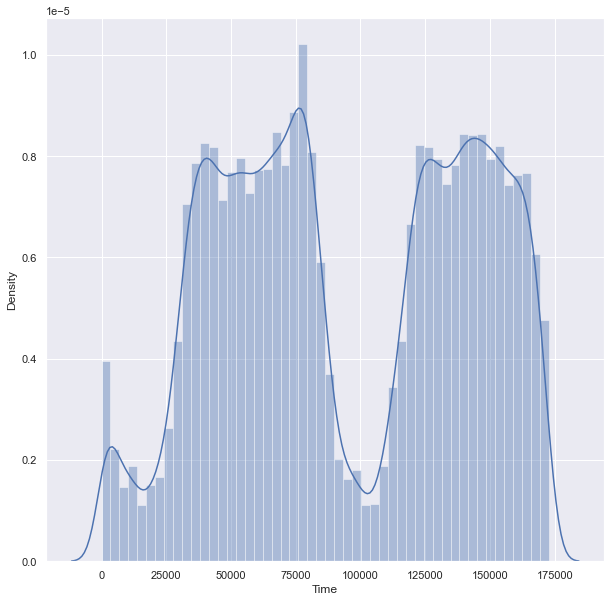

In [7]:
#Visualization of a distrubtion plot to find any insight between Non-Fradulent Class and Time
sns.set(rc={'figure.figsize':(10,10)})
sns.distplot(credit_dataset[credit_dataset['Class']==0]['Time'])

From EDA, it clear that the dataset is imbalanced and there are no correlations between the features

## Data preparation for the model

In [12]:
#Splitting features and target variables
X=credit_dataset.iloc[:,0:30]
Y = credit_dataset.iloc[:,-1:]
X,Y

(            Time         V1         V2        V3        V4        V5  \
 0            0.0  -1.359807  -0.072781  2.536347  1.378155 -0.338321   
 1            0.0   1.191857   0.266151  0.166480  0.448154  0.060018   
 2            1.0  -1.358354  -1.340163  1.773209  0.379780 -0.503198   
 3            1.0  -0.966272  -0.185226  1.792993 -0.863291 -0.010309   
 4            2.0  -1.158233   0.877737  1.548718  0.403034 -0.407193   
 ...          ...        ...        ...       ...       ...       ...   
 284802  172786.0 -11.881118  10.071785 -9.834783 -2.066656 -5.364473   
 284803  172787.0  -0.732789  -0.055080  2.035030 -0.738589  0.868229   
 284804  172788.0   1.919565  -0.301254 -3.249640 -0.557828  2.630515   
 284805  172788.0  -0.240440   0.530483  0.702510  0.689799 -0.377961   
 284806  172792.0  -0.533413  -0.189733  0.703337 -0.506271 -0.012546   
 
               V6        V7        V8        V9  ...       V20       V21  \
 0       0.462388  0.239599  0.098698  0.36378

In [13]:
#Splitting the data into train and test set

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, shuffle=True,random_state=999,stratify=Y)

### Xgboost Model Creation and Evaluation

/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:05:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.93      0.80      0.86       148

    accuracy                           1.00     85443
   macro avg       0.96      0.90      0.93     85443
weighted avg       1.00      1.00      1.00     85443



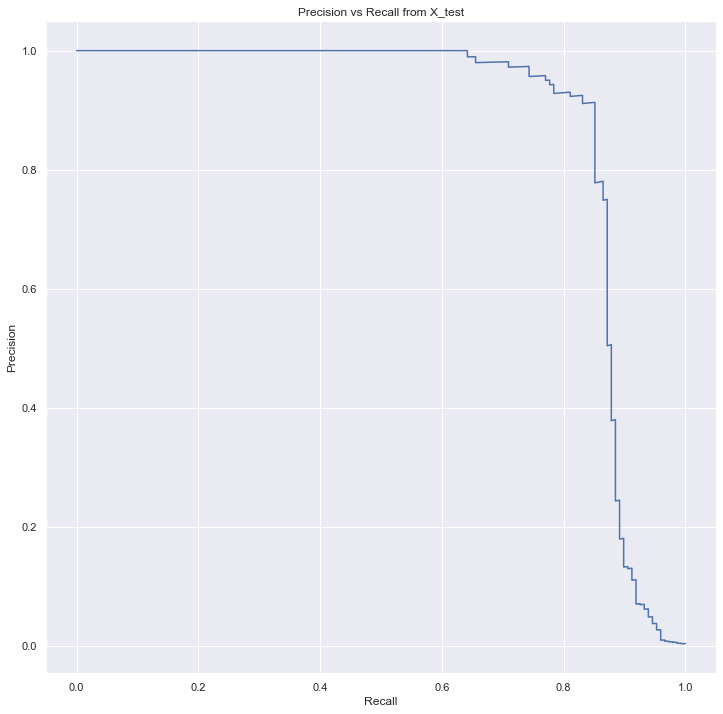

In [15]:
#Creating and fitting the data XGBoost Model
sns.set(rc={'figure.figsize':(12,12)})
model = XGBClassifier(n_estimators=100,learning_rate=0.3)
model.fit(X_train, y_train)

#Predicting the Classes from trained model on Xgboost
y_pred = model.predict(X_test)
proba = model.predict_proba(X_test)

#Classification report containing Precision-Recall value (Evaluation of the model)
values = classification_report(y_test, y_pred,target_names=['0','1'])
print(values)

#Plotting Precision-Recall curve
prec, rec, thresh = metrics.precision_recall_curve(y_test, proba[:,1], pos_label=None, sample_weight=None)
fig, ax = plt.subplots()
ax.plot(rec, prec, '-')
ax.set(xlabel='Recall', ylabel='Precision', title='Precision vs Recall from X_test')
plt.show()

### Random Forest model creation and Evaluation

<ipython-input-17-5c342bc3f244>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.94      0.78      0.85       148

    accuracy                           1.00     85443
   macro avg       0.97      0.89      0.93     85443
weighted avg       1.00      1.00      1.00     85443



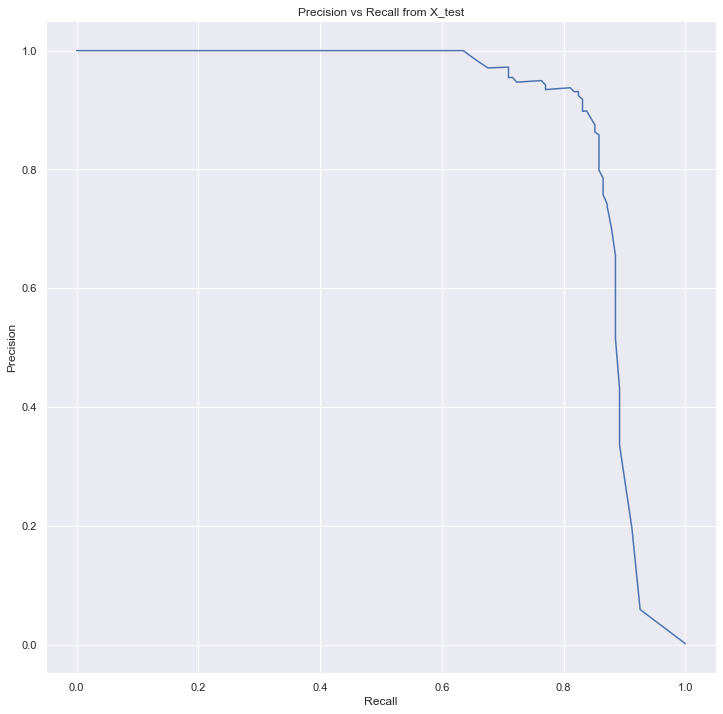

In [17]:
#Creating and fitting the data RandomForest Model
sns.set(rc={'figure.figsize':(12,12)})
clf = RandomForestClassifier(n_estimators =100, max_depth=None, random_state=42)
clf.fit(X_train, y_train)

#Predicting the Classes from trained model on RandomForest
y_pred_rf = clf.predict(X_test) 
predictions_rf = [round(value) for value in y_pred_rf]
proba_rf = clf.predict_proba(X_test)

#Classification report containing Precision-Recall value (Evaluation of the model)
values = classification_report(y_test, y_pred_rf,target_names=['0','1'])
print(values)

#Plotting Precision-Recall curve
prec, rec, thresh = metrics.precision_recall_curve(y_test, proba_rf[:,1], pos_label=None, sample_weight=None)
fig, ax = plt.subplots()
ax.plot(rec, prec, '-')
ax.set(xlabel='Recall', ylabel='Precision', title='Precision vs Recall from X_test')
plt.show()

### Logistic Regression model creation and evaluation

/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.64      0.69      0.66       148

    accuracy                           1.00     85443
   macro avg       0.82      0.84      0.83     85443
weighted avg       1.00      1.00      1.00     85443



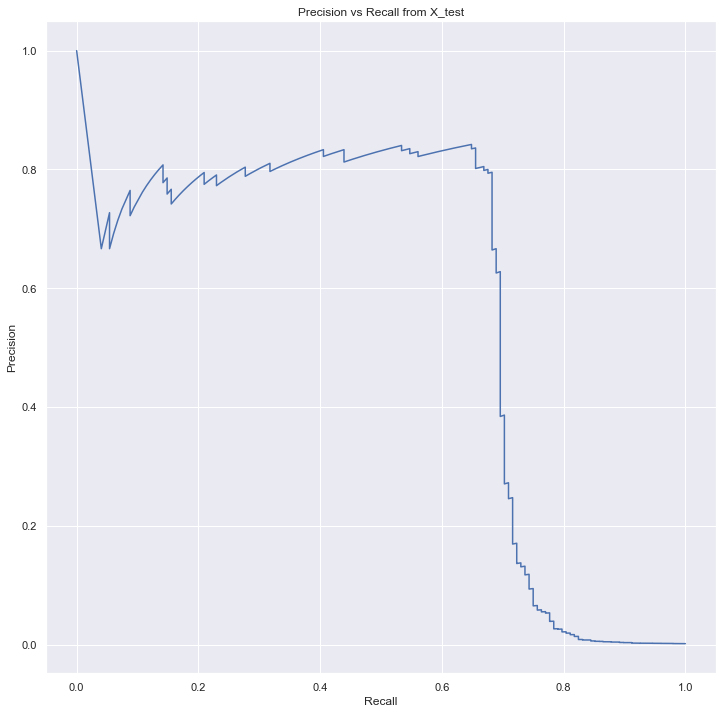

In [19]:
#Creating and fitting the data into Logistic Regression Model
sns.set(rc={'figure.figsize':(12,12)})
clf = LogisticRegression().fit(X_train, y_train)

#Predicting the Classes from trained model on Logistic Regression
y_pred_clf = clf.predict(X_test)
proba_clf = clf.predict_proba(X_test)

#Classification report containing Precision-Recall value (Evaluation of the model)
values_clf = classification_report(y_test, y_pred_clf,target_names=['0','1'])
print(values_clf)

#Plotting Precision-Recall curve
prec, rec, thresh = metrics.precision_recall_curve(y_test, proba_clf[:,1], pos_label=None, sample_weight=None)
fig, ax = plt.subplots()
ax.plot(rec, prec, '-')
ax.set(xlabel='Recall', ylabel='Precision', title='Precision vs Recall from X_test')
plt.show()

So far, from the performance of three models without applying any methods to balance the dataset is clearly visible that the best model is Xgboost based on Precision-Recall curve

## Applying Under sampling technique to training data in order to balance the dataset

In [21]:
print(Counter(y_train))
undersample = RandomUnderSampler(sampling_strategy='majority')
# fit and apply the transform
X_undersample, y_undersample = undersample.fit_resample(X_train, y_train)
# summarize class distribution
print(Counter(y_undersample))

Counter({'Class': 1})
Counter({'Class': 1})


### Xgboost Model Creation and Evaluation on undersampled data

/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:23:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     85295
           1       0.04      0.93      0.08       148

    accuracy                           0.96     85443
   macro avg       0.52      0.95      0.53     85443
weighted avg       1.00      0.96      0.98     85443



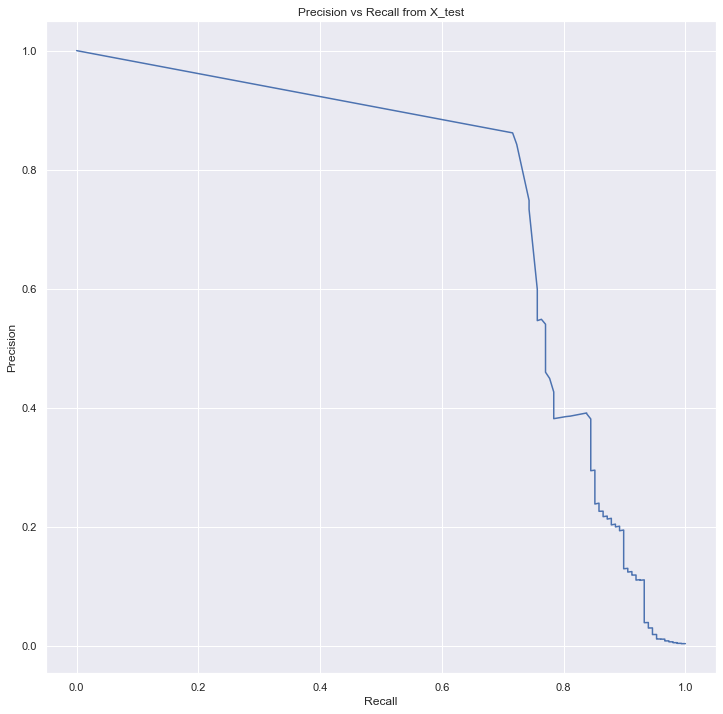

In [22]:
#Creating and fitting the data on XGBoost Model
sns.set(rc={'figure.figsize':(12,12)})
model_undersample = XGBClassifier(n_estimators=100,learning_rate=0.01)
model_undersample.fit(X_undersample, y_undersample)

#Predicting the Classes from trained model on Xgboost
y_pred_undersample = model_undersample.predict(X_test)
proba_undersample = model_undersample.predict_proba(X_test)

#Classification report containing Precision-Recall value (Evaluation of the model)
values = classification_report(y_test, y_pred_undersample,target_names=['0','1'])
print(values)


#Plotting Precision-Recall curve
prec, rec, thresh = metrics.precision_recall_curve(y_test, proba_undersample[:,1], pos_label=None, sample_weight=None)
fig, ax = plt.subplots()
ax.plot(rec, prec, '-')
ax.set(xlabel='Recall', ylabel='Precision', title='Precision vs Recall from X_test')
plt.show()

### Random Forest Model Creation and Evaluation on undersampled data

<ipython-input-23-1b5e8655c9d3>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_undersample, y_undersample)


              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85295
           1       0.07      0.93      0.14       148

    accuracy                           0.98     85443
   macro avg       0.54      0.96      0.56     85443
weighted avg       1.00      0.98      0.99     85443



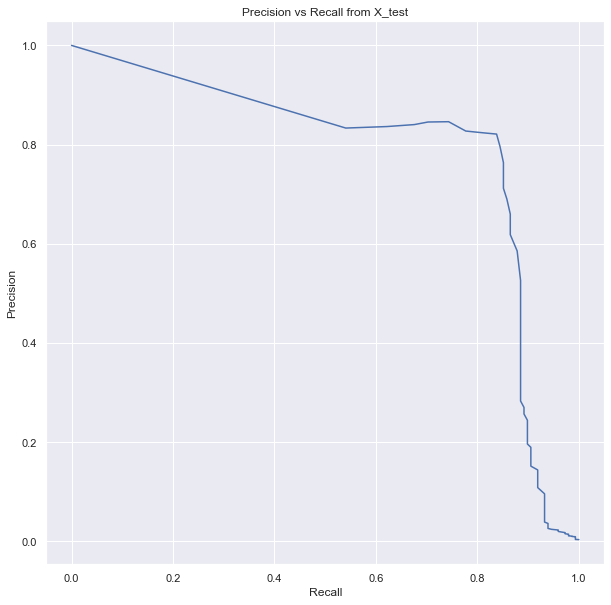

In [23]:
#Creating and fitting the data on Randomforest Model

clf = RandomForestClassifier(n_estimators =100, max_depth=None, random_state=42)
clf.fit(X_undersample, y_undersample)

#Predicting the Classes from trained model on Xgboost
y_pred_rf = clf.predict(X_test) 
proba_rf = clf.predict_proba(X_test)
predictions_rf = [round(value) for value in y_pred_rf]

#Classification report containing Precision-Recall value (Evaluation of the model)
values = classification_report(y_test, y_pred_rf,target_names=['0','1'])
print(values)

#Plotting Precision-Recall curve
sns.set(rc={'figure.figsize':(10,10)})
prec, rec, thresh = metrics.precision_recall_curve(y_test, proba_rf[:,1], pos_label=None, sample_weight=None)
fig, ax = plt.subplots()
ax.plot(rec, prec, '-')
ax.set(xlabel='Recall', ylabel='Precision', title='Precision vs Recall from X_test')
plt.show()

It is clearly visible from the above two classifiers ie., Xgboost and Random forest that precision is very low
and the method of undersampling is not feasible with credit card data

## Applying Oversampling technique ie., SMOTE SAMPLING on training data

In [24]:
print(Counter(y_train))
# fit and apply the transform
oversample=SMOTE()
X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)
#summarize class distribution
print(Counter(y_train_smote))

Counter({'Class': 1})
Counter({'Class': 1})


### Xgboost Model Creation and Evaluation on oversampled data

/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[17:08:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.87      0.88      0.88       148

    accuracy                           1.00     85443
   macro avg       0.94      0.94      0.94     85443
weighted avg       1.00      1.00      1.00     85443



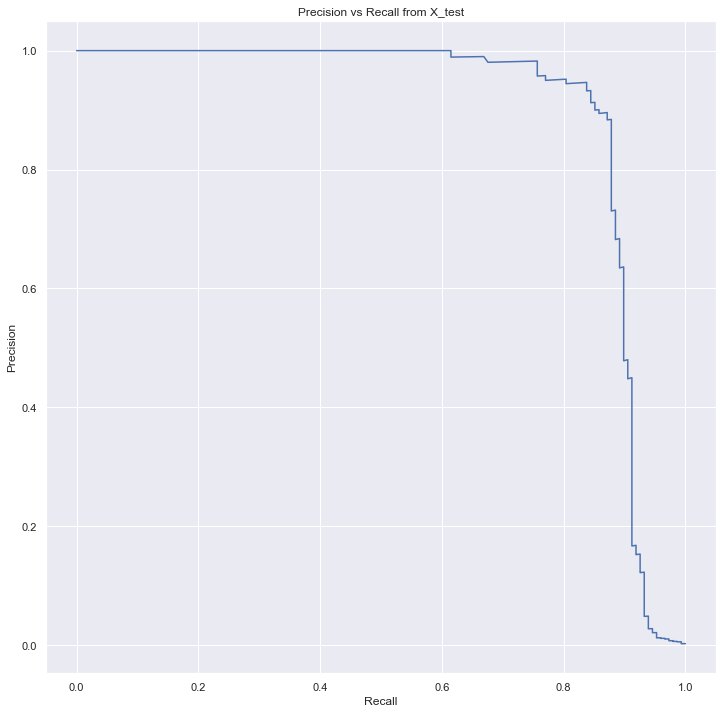

In [38]:
#Creating and fitting the data on XGBoost Model
sns.set(rc={'figure.figsize':(12,12)})
model_smote = XGBClassifier(n_estimators=200,learning_rate=0.3)
model_smote.fit(pd.DataFrame(X_train_smote,columns=X.columns), y_train_smote)

#Predicting the Classes from trained model on Xgboost
y_pred_smote = model_smote.predict(X_test)
proba_smote = model_smote.predict_proba(X_test)

#Classification report containing Precision-Recall value (Evaluation of the model)
values_smote = classification_report(y_test, y_pred_smote,target_names=['0','1'])
print(values_smote)

#Plotting Precision-Recall curve
prec, rec, thresh = metrics.precision_recall_curve(y_test, proba_smote[:,1], pos_label=None, sample_weight=None)
fig, ax = plt.subplots()
ax.plot(rec, prec, '-')
ax.set(xlabel='Recall', ylabel='Precision', title='Precision vs Recall from X_test')
plt.show()

<AxesSubplot:>

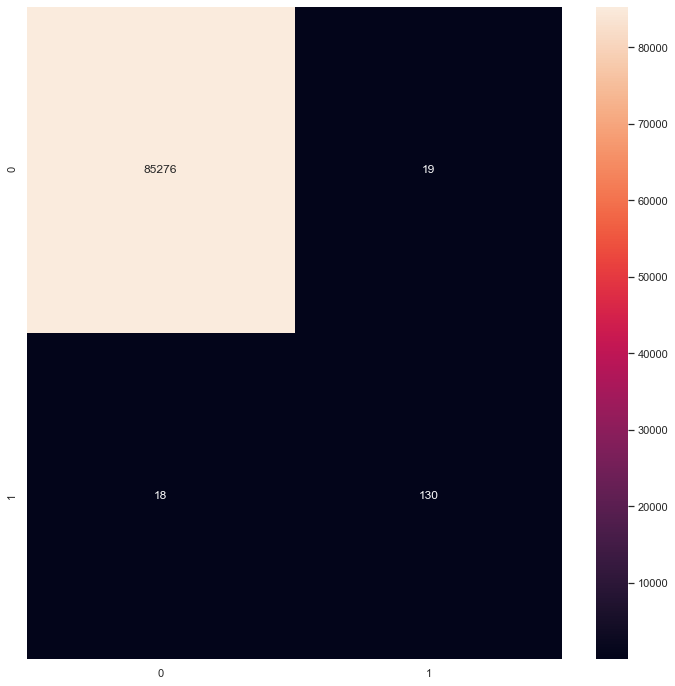

In [40]:
sns.heatmap(confusion_matrix(y_test,y_pred_smote),fmt='d',annot=True)

### RandomForest Model creation and Evaluation on oversampled data

<ipython-input-28-244e33d6e670>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf_smote.fit(X_train_smote, y_train_smote)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.88      0.85      0.87       148

    accuracy                           1.00     85443
   macro avg       0.94      0.93      0.93     85443
weighted avg       1.00      1.00      1.00     85443



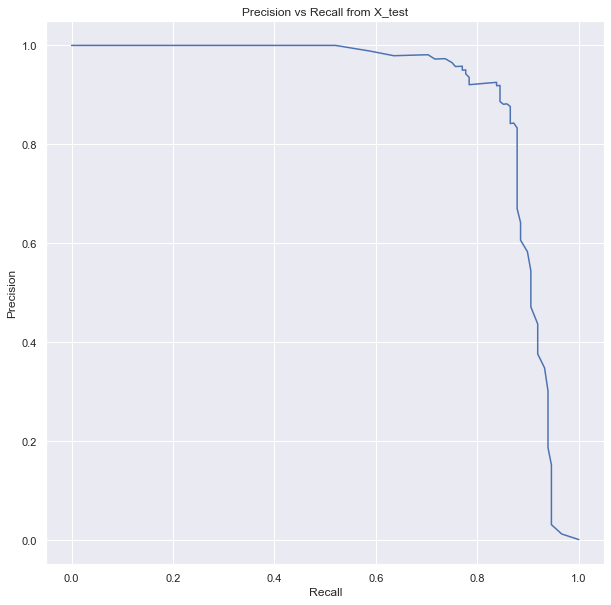

In [28]:
#Creating and fitting the data on Randomforest Model

clf_smote = RandomForestClassifier(n_estimators =100, max_depth=None, random_state=42)
clf_smote.fit(X_train_smote, y_train_smote)

#Predicting the Classes from trained model on Xgboost
y_pred_rf = clf_smote.predict(X_test) 
proba_rf = clf_smote.predict_proba(X_test)
predictions_rf = [round(value) for value in y_pred_rf]

#Classification report containing Precision-Recall value (Evaluation of the model)
values = classification_report(y_test, y_pred_rf,target_names=['0','1'])
print(values)

#Plotting Precision-Recall curve
sns.set(rc={'figure.figsize':(10,10)})
prec, rec, thresh = metrics.precision_recall_curve(y_test, proba_rf[:,1], pos_label=None, sample_weight=None)
fig, ax = plt.subplots()
ax.plot(rec, prec, '-')
ax.set(xlabel='Recall', ylabel='Precision', title='Precision vs Recall from X_test')
plt.show()

From the above two models on oversampled data, it is clear that Xgboost with Oversampled data is the best fit based on Precision and recall when compared to undersampling

## Feature importance 
on selected model i.e., Xgboost with Oversampled data to further increase the performance of the model

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

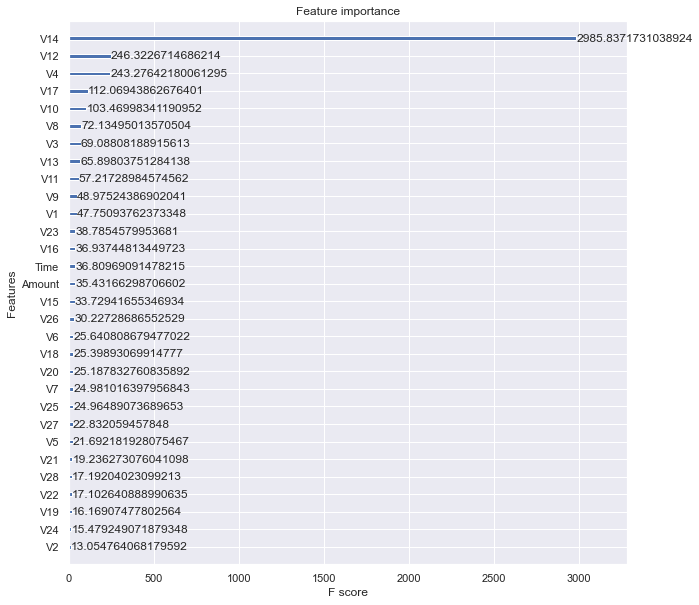

In [30]:
plot_importance(model_smote, importance_type='gain')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

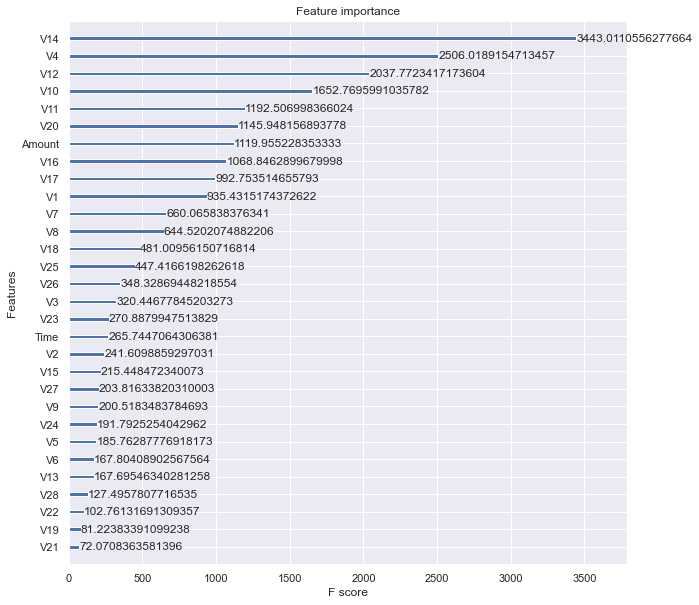

In [31]:
plot_importance(model_smote, importance_type='cover')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

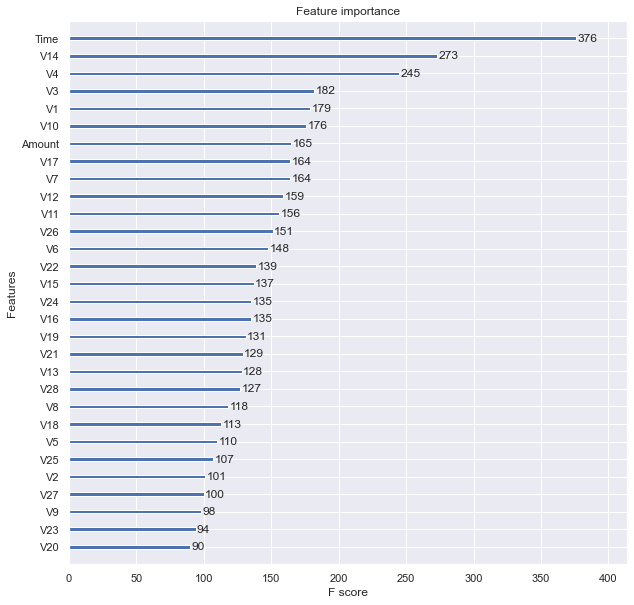

In [32]:
plot_importance(model_smote, importance_type='weight')

In [29]:
#Analyticsvidhya website

thresholds = sorted(model_smote.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model_smote, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train_smote)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train_smote)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    proba_smote = model_smote.predict_proba(X_test)
    values_smote = classification_report(y_test, y_pred,target_names=['0','1'])
    print(values_smote)
    accuracy = accuracy_score(y_test, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))


/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:42:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.86      0.88      0.87       148

    accuracy                           1.00     85443
   macro avg       0.93      0.94      0.93     85443
weighted avg       1.00      1.00      1.00     85443

Thresh=0.003, n=30, Accuracy: 99.95%


/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:43:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.85      0.86      0.86       148

    accuracy                           1.00     85443
   macro avg       0.93      0.93      0.93     85443
weighted avg       1.00      1.00      1.00     85443

Thresh=0.003, n=29, Accuracy: 99.95%


/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:43:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.83      0.86      0.84       148

    accuracy                           1.00     85443
   macro avg       0.91      0.93      0.92     85443
weighted avg       1.00      1.00      1.00     85443

Thresh=0.004, n=28, Accuracy: 99.94%


/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:44:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.90      0.87      0.88       148

    accuracy                           1.00     85443
   macro avg       0.95      0.94      0.94     85443
weighted avg       1.00      1.00      1.00     85443

Thresh=0.004, n=27, Accuracy: 99.96%


/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:44:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.86      0.86      0.86       148

    accuracy                           1.00     85443
   macro avg       0.93      0.93      0.93     85443
weighted avg       1.00      1.00      1.00     85443

Thresh=0.004, n=26, Accuracy: 99.95%


/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:45:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.84      0.86      0.85       148

    accuracy                           1.00     85443
   macro avg       0.92      0.93      0.92     85443
weighted avg       1.00      1.00      1.00     85443

Thresh=0.004, n=25, Accuracy: 99.95%


/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:45:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.84      0.86      0.85       148

    accuracy                           1.00     85443
   macro avg       0.92      0.93      0.93     85443
weighted avg       1.00      1.00      1.00     85443

Thresh=0.005, n=24, Accuracy: 99.95%


/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:46:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.86      0.87      0.87       148

    accuracy                           1.00     85443
   macro avg       0.93      0.94      0.93     85443
weighted avg       1.00      1.00      1.00     85443

Thresh=0.005, n=23, Accuracy: 99.95%


/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:46:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.86      0.86      0.86       148

    accuracy                           1.00     85443
   macro avg       0.93      0.93      0.93     85443
weighted avg       1.00      1.00      1.00     85443

Thresh=0.006, n=22, Accuracy: 99.95%


/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:47:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.83      0.86      0.85       148

    accuracy                           1.00     85443
   macro avg       0.92      0.93      0.92     85443
weighted avg       1.00      1.00      1.00     85443

Thresh=0.006, n=21, Accuracy: 99.95%


/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:47:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.82      0.85      0.83       148

    accuracy                           1.00     85443
   macro avg       0.91      0.93      0.92     85443
weighted avg       1.00      1.00      1.00     85443

Thresh=0.006, n=20, Accuracy: 99.94%


/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:48:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.85      0.87      0.86       148

    accuracy                           1.00     85443
   macro avg       0.92      0.94      0.93     85443
weighted avg       1.00      1.00      1.00     85443

Thresh=0.006, n=19, Accuracy: 99.95%


/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:48:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.82      0.86      0.84       148

    accuracy                           1.00     85443
   macro avg       0.91      0.93      0.92     85443
weighted avg       1.00      1.00      1.00     85443

Thresh=0.006, n=18, Accuracy: 99.94%


/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:49:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.79      0.87      0.83       148

    accuracy                           1.00     85443
   macro avg       0.89      0.94      0.91     85443
weighted avg       1.00      1.00      1.00     85443

Thresh=0.007, n=17, Accuracy: 99.94%


/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:49:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.79      0.88      0.83       148

    accuracy                           1.00     85443
   macro avg       0.89      0.94      0.92     85443
weighted avg       1.00      1.00      1.00     85443

Thresh=0.007, n=16, Accuracy: 99.94%


/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:50:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.77      0.87      0.82       148

    accuracy                           1.00     85443
   macro avg       0.89      0.94      0.91     85443
weighted avg       1.00      1.00      1.00     85443

Thresh=0.008, n=15, Accuracy: 99.93%


/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:50:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.72      0.87      0.79       148

    accuracy                           1.00     85443
   macro avg       0.86      0.94      0.90     85443
weighted avg       1.00      1.00      1.00     85443

Thresh=0.008, n=14, Accuracy: 99.92%


/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:51:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.62      0.86      0.73       148

    accuracy                           1.00     85443
   macro avg       0.81      0.93      0.86     85443
weighted avg       1.00      1.00      1.00     85443

Thresh=0.008, n=13, Accuracy: 99.89%


/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:51:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.57      0.86      0.68       148

    accuracy                           1.00     85443
   macro avg       0.78      0.93      0.84     85443
weighted avg       1.00      1.00      1.00     85443

Thresh=0.009, n=12, Accuracy: 99.86%


/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:51:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.52      0.87      0.65       148

    accuracy                           1.00     85443
   macro avg       0.76      0.94      0.83     85443
weighted avg       1.00      1.00      1.00     85443

Thresh=0.011, n=11, Accuracy: 99.84%


/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:52:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.54      0.86      0.66       148

    accuracy                           1.00     85443
   macro avg       0.77      0.93      0.83     85443
weighted avg       1.00      1.00      1.00     85443

Thresh=0.011, n=10, Accuracy: 99.85%


/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:52:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.49      0.86      0.62       148

    accuracy                           1.00     85443
   macro avg       0.74      0.93      0.81     85443
weighted avg       1.00      1.00      1.00     85443

Thresh=0.013, n=9, Accuracy: 99.82%


/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:52:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.41      0.86      0.56       148

    accuracy                           1.00     85443
   macro avg       0.71      0.93      0.78     85443
weighted avg       1.00      1.00      1.00     85443

Thresh=0.015, n=8, Accuracy: 99.76%


/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:53:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.37      0.87      0.52       148

    accuracy                           1.00     85443
   macro avg       0.69      0.93      0.76     85443
weighted avg       1.00      1.00      1.00     85443

Thresh=0.015, n=7, Accuracy: 99.72%


/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:53:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.26      0.88      0.40       148

    accuracy                           1.00     85443
   macro avg       0.63      0.94      0.70     85443
weighted avg       1.00      1.00      1.00     85443

Thresh=0.016, n=6, Accuracy: 99.55%


/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:53:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     85295
           1       0.18      0.86      0.30       148

    accuracy                           0.99     85443
   macro avg       0.59      0.93      0.65     85443
weighted avg       1.00      0.99      1.00     85443

Thresh=0.023, n=5, Accuracy: 99.29%


/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:54:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     85295
           1       0.12      0.89      0.21       148

    accuracy                           0.99     85443
   macro avg       0.56      0.94      0.60     85443
weighted avg       1.00      0.99      0.99     85443

Thresh=0.025, n=4, Accuracy: 98.86%


/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:54:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85295
           1       0.07      0.89      0.14       148

    accuracy                           0.98     85443
   macro avg       0.54      0.93      0.56     85443
weighted avg       1.00      0.98      0.99     85443

Thresh=0.054, n=3, Accuracy: 98.09%


/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:54:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85295
           1       0.07      0.90      0.13       148

    accuracy                           0.98     85443
   macro avg       0.53      0.94      0.56     85443
weighted avg       1.00      0.98      0.99     85443

Thresh=0.054, n=2, Accuracy: 97.82%


/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[15:54:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     85295
           1       0.04      0.91      0.08       148

    accuracy                           0.96     85443
   macro avg       0.52      0.94      0.53     85443
weighted avg       1.00      0.96      0.98     85443

Thresh=0.659, n=1, Accuracy: 96.49%


From the above feature importance performance, it is clear that if the number of features are decreasing,
precision is decreasing except for the case (n=27) i.e, number of features are 27, precision is 90%, and 
recall is 87%

## Implementing hyperparameter tuning with Gridsearch CV

In [ ]:
#values for hyper parameters
params = {
     'learning_rate': [0.2,0.3],
     'n_estimators': [100,200],
     'max_depth':[7,8],
     'reg_alpha':[0.3,0.4]
    }
xgb_model = XGBClassifier()
gsearch = GridSearchCV(xgb_model, params,
                    verbose=True,
                    cv=5,
                    n_jobs=2)
gsearch.fit(X_train_smote, y_train_smote)
print("Best Parameters :",gsearch.best_params_)
params = {'objective':'binary:logistic', 'booster':'gbtree'}
# Updating the parameter as per grid search
params.update(gsearch.best_params_)
# Initializing the XGBoost Classifier
xgb_model = xgb.XGBClassifier(**params)
print(xgb_model)

#fitting the model with best parameters and prediction
xgb_model.fit(X_train_smote, y_train_smote)
y_pred_smote = model.predict(X_test) 
predictions = [round(value) for value in y_pred]
proba_smote = model.predict_proba(X_test)
values_smote = classification_report(y_test, y_pred_smote,target_names=['0','1'])
print(values_smote)

#Precision-recall curve
prec, rec, thresh = metrics.precision_recall_curve(y_test, proba_smote[:,1], pos_label=None, sample_weight=None)
fig, ax = plt.subplots()
ax.plot(rec, prec, '-')
ax.set(xlabel='Recall', ylabel='Precision', title='Precision vs Recall from X_test')
plt.show()


<AxesSubplot:>

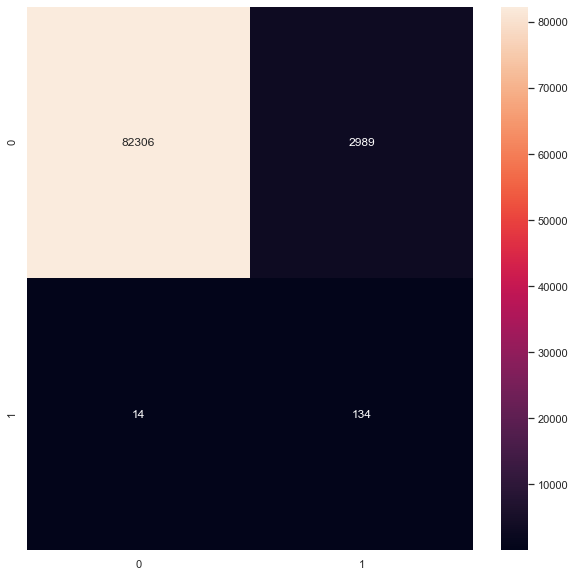

In [37]:
sns.heatmap(confusion_matrix(y_test,predictions),fmt='d',annot=True)

From the above parameter tuning, we have more number of false positives, when comppared to our best model so far i.e., Xgboost with Oversampling.

So, the model which will be deployed further on flask is Xgboost with Oversampling)

In [42]:
# Saving the model to .pkl file
with open('model.pkl','wb') as fe_data_file:
     pickle.dump(model_smote, fe_data_file)

### Random check for PCA(Principal Component Analysis)

In [46]:
from sklearn.preprocessing import StandardScaler
x = X
x = StandardScaler().fit_transform(x)
x

array([[-1.99658302, -0.69424232, -0.04407492, ...,  0.33089162,
        -0.06378115,  0.24496426],
       [-1.99658302,  0.60849633,  0.16117592, ..., -0.02225568,
         0.04460752, -0.34247454],
       [-1.99656197, -0.69350046, -0.81157783, ..., -0.13713686,
        -0.18102083,  1.16068593],
       ...,
       [ 1.6419735 ,  0.98002374, -0.18243372, ...,  0.01103672,
        -0.0804672 , -0.0818393 ],
       [ 1.6419735 , -0.12275539,  0.32125034, ...,  0.26960398,
         0.31668678, -0.31324853],
       [ 1.64205773, -0.27233093, -0.11489898, ..., -0.00598394,
         0.04134999,  0.51435531]])

In [47]:
from sklearn.decomposition import PCA
pca = PCA(n_components=7)
principalComponents_breast = pca.fit_transform(x)

print(pca.explained_variance_ratio_)

print(pca.explained_variance_)

[0.0652562  0.05581941 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333]
[1.95769294 1.67458808 1.00000351 1.00000351 1.00000351 1.00000351
 1.00000351]


In [58]:
names=['Time','Amount','Transaction Method','Transaction Id','Location','Type of Card','Bank']

X_reduced= pd.DataFrame(principalComponents_breast,columns=names)
X_reduced.head()
X_reduced.shape
X_reduced

,Time,Amount,Transaction Method,Transaction Id,Location,Type of Card,Bank
0,0.434977,-2.602931,-0.162586,-0.428826,-0.626127,-1.421780,0.380816
1,-0.399302,-2.089272,0.433134,0.706978,0.587065,0.682880,-0.485283
2,1.853230,-2.557714,1.375440,0.930954,0.204444,-0.271563,-1.024656
3,0.350743,-1.819941,1.168011,0.854238,-0.952903,0.038597,0.601689
4,0.014996,-1.607238,-1.135241,0.082065,-0.903849,-0.231567,0.299929
...,...,...,...,...,...,...,...
284802,-1.619961,1.994060,-2.147442,0.490494,0.141744,-4.846341,-0.060315
284803,-0.362024,0.725070,0.395166,1.743368,-0.478149,-0.352695,-0.894746
284804,-0.230174,2.003305,0.684515,-0.963174,0.554644,1.061328,0.577948
284805,-0.471239,0.895543,-1.164578,-1.933252,-0.811576,-1.371640,-0.576869


In [49]:
new_data=pd.concat([X_reduced,Y],axis=1)
new_data.head()
new_data.shape

(284807, 8)

In [50]:
X_train, X_test, y_train, y_test= train_test_split(X_reduced, Y, test_size = 0.30, random_state = 42)

X_train.shape, X_test.shape

((199364, 7), (85443, 7))

In [51]:
print(Counter(y_train))
# fit and apply the transform
oversample=SMOTE()
X_train_smote1, y_train_smote1 = oversample.fit_resample(X_train, y_train)
#summarize class distribution
print(Counter(y_train_smote1))

Counter({'Class': 1})
Counter({'Class': 1})


In [55]:
X_train_smote1.shape

(398016, 7)

/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/Cellar/jupyterlab/3.0.14/libexec/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[17:54:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.94      0.71      0.81       136

    accuracy                           1.00     85443
   macro avg       0.97      0.86      0.91     85443
weighted avg       1.00      1.00      1.00     85443



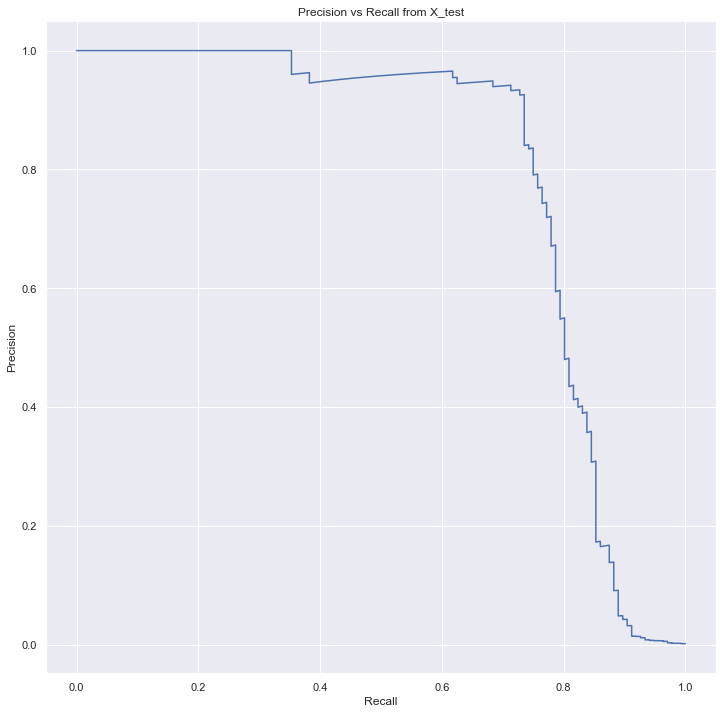

In [62]:
#Creating and fitting the data on XGBoost Model
sns.set(rc={'figure.figsize':(12,12)})
model_smote = XGBClassifier(n_estimators=200,learning_rate=0.3)
model_smote.fit(X_train, y_train)

#Predicting the Classes from trained model on Xgboost
y_pred_smote = model_smote.predict(X_test)
proba_smote = model_smote.predict_proba(X_test)

#Classification report containing Precision-Recall value (Evaluation of the model)
values_smote = classification_report(y_test, y_pred_smote,target_names=['0','1'])
print(values_smote)

#Plotting Precision-Recall curve
prec, rec, thresh = metrics.precision_recall_curve(y_test, proba_smote[:,1], pos_label=None, sample_weight=None)
fig, ax = plt.subplots()
ax.plot(rec, prec, '-')
ax.set(xlabel='Recall', ylabel='Precision', title='Precision vs Recall from X_test')
plt.show()

From all the results, based upon all the methods, I can say Xgboost with Smote oversampling is giving better results!!